In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import umap

2024-02-15 20:54:41.988375: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 20:54:42.013509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 20:54:42.013537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 20:54:42.013552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 20:54:42.019548: I tensorflow/core/platform/cpu_feature_g

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2024-02-15 20:54:46.175900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 20:54:46.180285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 20:54:46.180315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 20:54:46.182766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 20:54:46.182795: I tensorflow/compile

In [4]:
df = pd.read_csv('../../../datos/2023/July/2023-07-01.csv', nrows=100000)
df

,block_timestamp,nonce,from_address,to_address,value,gas
0,2023-07-01 00:06:47+00:00,461958,0x292f04a44506c2fd49bac032e1ca148c35a478c8,0xf1a7b0f702eaf433e4697b766306bca41985b75a,881375944790000,55000
1,2023-07-01 00:06:47+00:00,129,0x5c80ae7a02b36c392e34f28859c9dc7a4ecb544f,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,6000000000000000,205047
2,2023-07-01 00:06:47+00:00,38,0xc845914efd144c75d2ffeec2f9609b3bebad681e,0x82e0b8cdd80af5930c4452c684e71c861148ec8a,6000000000000000,202640
3,2023-07-01 00:06:47+00:00,199,0x2bf23d3ab2fe916232ac836b42dc542884df45ae,0x881d40237659c251811cec9c364ef91dc08d300c,300000000000000000,352654
4,2023-07-01 00:33:47+00:00,30,0x78d0365355790d602b571dca709564239954aef6,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,10000000000000000,401234
...,...,...,...,...,...,...
99995,2023-07-01 12:12:47+00:00,1,0xa37602a8f3d0a28a194477f1f97e03a4f76aa0c4,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,8131588964253603,21000
99996,2023-07-01 12:12:47+00:00,1,0x03f9edbbae29a3eed80f0724fef91a8045e73bb0,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,66626488222879315,21000
99997,2023-07-01 09:36:35+00:00,1,0x46945e6f687317841bdbb06dcad812f4f660da40,0xec554417cb64c7433bb2f84a46b9ad633dd457c6,150576440261296251,21000
99998,2023-07-01 09:36:35+00:00,1,0x7096b6674f74bd55a9ccad314b69d84bf2a94c32,0x12ec7e9ebf97f7393de7e6c3c920ec03c4edcf02,6483811281420584,21000


In [5]:
df_aux = df\
    .groupby(['from_address', 'to_address'])\
    .agg({ 'block_timestamp': 'count', 'value': 'sum' })\
    .rename(columns={'block_timestamp': 'count_transactions', 'value': 'total_amount'})\
    .reset_index()
df_aux

,from_address,to_address,count_transactions,total_amount
0,0x00000000000124d994209fbb955e0217b5c2eca1,0x445947140f5e1b742439f6ee24a7690d077bbb89,7,1760094799433647176016974901612917598334101392...
1,0x0000000000055772357e58581a2a2c5c6d9e8f64,0xc0de02babe048d279d1ac193930169e715fe7612,7,1760074317600974176025471760063317597256175957...
2,0x00000000000a33e9749fb3d57b98a5f4c1fbfe5c,0xf5bf5dcdaa83fd358b5a4eced76f3b947542175a,2,13716573859333812190947675457255
3,0x000000002d4db35b28c690a28a7b4d58f1e2c738,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,1,100000000000000000
4,0x00000000765099b17a0aedd27efde2353aefddea,0x00000000e028bace110a6f479b54cd95fc953035,1,1000000000000000000
...,...,...,...,...
79879,0xfffceb755439ac0144783170239a82004c066daf,0xb2b4a8dafecb1b9377c37afb345af72df00539fb,1,152300000000000000
79880,0xfffe24cf52f43f56b76e1f74cd326d4a07784826,0xe24b6cba5089c3abd59144736c39b50a2c8e263a,1,1000000000000000
79881,0xfffe9b405079a8d4a63a979f82a3044a09c5a320,0x0c349951714c8d674bbe84a2191fcbc12c76c8d0,1,1323707239545000
79882,0xfffea3a6b849d1cf86a32e2105214ebe90fdc3f0,0x831d4898a0856edfafd6d375d5e3753312617364,1,2500000000000000


In [8]:
df_aux[['count_transactions', 'total_amount']].values

array([[7,
        '1760094799433647176016974901612917598334101392751759674190181807176120089255333117601919802130401759714347264063'],
       [7, '17600743176009741760254717600633175972561759571817596286'],
       [2, '13716573859333812190947675457255'],
       ...,
       [1, '1323707239545000'],
       [1, '2500000000000000'],
       [2, '120000000000000000200000000000000000']], dtype=object)

In [4]:
(df["from_address"] == df["to_address"]).sum()

434

In [5]:
df = df[df["from_address"] != df["to_address"]]

In [6]:
(df["from_address"] == df["to_address"]).sum()

0

In [7]:
df.columns

Index(['block_timestamp', 'nonce', 'from_address', 'to_address', 'value',
       'gas'],
      dtype='object')

In [8]:
len(set(df['from_address']).union(set(df['to_address'])))

310475

In [9]:
df = df[~df.to_address.isna()]
df = df[~df.from_address.isna()]

In [10]:
ids = {}

for i, id in enumerate(set(df['from_address']).union(set(df['to_address']))):
    ids[id] = i

In [11]:
ids

{'0x3bc077020629ac8f5581512ee113d4ad0aaaefa4': 0,
 '0x761d90d3c58f0a741de23356c81bc5c321765f45': 1,
 '0x20f0e660b638c7841e8990af73df781fa666680a': 2,
 '0xdd758e0c0ef9b73cd8fd6451b9a29b4572f92162': 3,
 '0xb836c1712d7882fe3f0f417c523490b97cfdb43c': 4,
 '0x2fd609a7e77704c9754ea6a305045c6a49e370fa': 5,
 '0x3d7262fd87aae02a3cd659a27fa3e41111edd419': 6,
 '0x60529c62047415533bb7cef0e95a89ecf72f1ba5': 7,
 '0xf3bbaf55ca45c9220fc5cd91c43eb93e14f3a6bf': 8,
 '0xdd56a5407930061adf50f692bca575f5ec015f2c': 9,
 '0x2913d0bbe4dac13b52bdfb9326d2630f02df6383': 10,
 '0x30160e7539810fb9687f926dbe1d6d6acd442205': 11,
 '0x5eda71e6e673967cbf22e95371f324e9f8075192': 12,
 '0x8ff99ab8351c31fedfec03ef642063324b80fa99': 13,
 '0xfe80938ef845338e95e834e6f61e92f4a38a71a3': 14,
 '0xf75977eb5c51769cc9377edfcf0d9f96b9edb920': 15,
 '0x08635ba468367fc533dd529c3b7a28f08126a3fb': 16,
 '0x56ebd460e692fa1474773f1aa1c2735fbb19925d': 17,
 '0x057798ed1daf6997be7579ba72c2c7706c2f4f34': 18,
 '0x503947a5cef142ba1bab62c6589544ab02e09

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, UnitNormalization, Lambda, GaussianNoise


# el 1 representa a cualquier indice, un tensor de una dimensión
input_aux = Input(1)

# el 128 es arbitrario, podría ser de cualquier valor
x = Embedding(len(ids), 128)(input_aux)

x = GaussianNoise(0.02)(x)

# TODO: investigar que es esto
x = Dense(64)(x)
# lleva todos los valores entre -1 y 1
output_aux = Dense(64)(x)

model_aux = Model(input_aux, output_aux)
model_aux.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 1, 128)            39740288  
                                                                 
 gaussian_noise_1 (Gaussian  (None, 1, 128)            0         
 Noise)                                                          
                                                                 
 dense_2 (Dense)             (None, 1, 64)             8256      
                                                                 
 dense_3 (Dense)             (None, 1, 64)             4160      
                                                                 
Total params: 39752704 (151.64 MB)
Trainable params: 39752704 (151.64 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [31]:
from tensorflow.keras.layers import Dot, Concatenate

# son los 3 inputs que representan las 3 cabezas de la red, lo que se conoce como siamesa
input_layer_anchor = Input(1)
input_layer_positive = Input(1)
input_layer_negative = Input(1)

x_a = model_aux(input_layer_anchor)
x_p = model_aux(input_layer_positive)
x_n = model_aux(input_layer_negative)

# un tensor es ... investigar bien. Puede ser cualquier cosa, literalmente.
# merged_output = Lambda(lambda tensors: tf.stack(tensors, axis=-1))([x_a, x_p, x_n])

merged_output = Concatenate(axis=-1)([x_a, x_p, x_n])

model = Model([input_layer_anchor, input_layer_positive, input_layer_negative], merged_output)

In [32]:
from keras.utils import Sequence
import numpy as np

class GeneratorTriplet(Sequence):
    def __init__(self, df, ids, batch_size):
        self.df = df
        self.act_index = 0
        self.ids = ids
        self.batch_size = batch_size
        self.limit = int(np.ceil(len(self.df) / self.batch_size))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.act_index < self.limit:
            resultado = self.__getitem__(self.act_index)
            self.act_index += 1
            return resultado
        else:
            raise StopIteration

    def __getitem__(self, index):
        # el Anchor es un A, el positive es un B y el negative es un C. Queremos acercar A y B tanto como sea posible alejando a C. Podría suceder que sea un vecino, pero la probabilidad es baja porque es al azar.
        # Si llegara a elegir algún vecino mal, de casualidad, en una siguiente epoch debería corregirse o inclusive en una misma epoch en una siguiente iteración del generador.
        init = index * self.batch_size
        end = (index + 1) * self.batch_size

        # el batch van a ser #batch_size tuplas que representan el anchor y positive. El negative es un random.
        batch = self.df[init:end]

        # me agarro un sample de #batch_size transacciones.
        negative = self.df.sample(len(batch))

        anchor = np.array(batch['from_address'].apply(lambda x: self.ids.get(x)))
        positive = np.array(batch['to_address'].apply(lambda x: self.ids.get(x)))
        negative = np.array(negative['to_address'].apply(lambda x: self.ids.get(x)))
        
        anchor = tf.convert_to_tensor(anchor)
        positive = tf.convert_to_tensor(positive)
        negative = tf.convert_to_tensor(negative)
        
        # el fake target simula lo que sería aprendizaje supervisado        
        fake_target = tf.convert_to_tensor(np.array([1]*self.batch_size))

        return ([anchor, positive, negative], [fake_target, fake_target, fake_target] * 3)

In [33]:
generator = GeneratorTriplet(df, ids, 128)

In [34]:
from tensorflow.keras.losses import CosineSimilarity

class TripletCustom(tf.keras.losses.Loss):
    def __init__(self, margin=0.2, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin

    def __call__(self, y, y_pred, sample_weight=None):
        x_a, x_p, x_n = tf.split(y_pred, num_or_size_splits=3, axis=-1)

        distance_positive = 1 - CosineSimilarity()(x_a, x_p)
        distance_negative = 1 - CosineSimilarity()(x_a, x_n)

        loss = tf.maximum(distance_positive - distance_negative + self.margin, 0.0)
        return tf.reduce_mean(loss)

loss = TripletCustom() 

model.compile(
    optimizer=Adam(1e-3),
    loss=loss
)

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, min_delta=1e-6)

In [36]:
model.fit(generator, epochs=600, callbacks=[callback])

Epoch 1/600
4005/4005 [==============================] - 73s 18ms/step - loss: 0.0290
Epoch 2/600
4005/4005 [==============================] - 60s 15ms/step - loss: 0.0022
Epoch 3/600
4005/4005 [==============================] - 62s 16ms/step - loss: 0.0013
Epoch 4/600
4005/4005 [==============================] - 61s 15ms/step - loss: 7.0622e-04
Epoch 5/600
4005/4005 [==============================] - 62s 15ms/step - loss: 7.1912e-04
Epoch 6/600
4005/4005 [==============================] - 60s 15ms/step - loss: 5.2207e-04
Epoch 7/600
4005/4005 [==============================] - 60s 15ms/step - loss: 4.1976e-04
Epoch 8/600
4005/4005 [==============================] - 61s 15ms/step - loss: 3.7799e-04
Epoch 9/600
4005/4005 [==============================] - 61s 15ms/step - loss: 2.8524e-04
Epoch 10/600
4005/4005 [==============================] - 62s 15ms/step - loss: 3.8725e-04
Epoch 11/600
4005/4005 [==============================] - 61s 15ms/step - loss: 1.9425e-04
Epoch 12/600
4005/40

# Guardo el embedding y los ids

In [38]:
import pickle

embedding_matrix = model_aux.get_layer(name="embedding_1").get_weights()
np.array(embedding_matrix).dump("embedding_matrix.npy")

with open('ids.pkl', 'wb') as f:
    pickle.dump(ids, f)

In [3]:
embedding_matrix = np.load("embedding_matrix.npy", allow_pickle=True)
embedding = umap.UMAP(n_components=2).fit(embedding_matrix[0])

/home/nahuel/.cache/pypoetry/virtualenvs/pow_a_pos-K56kznNs-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


### Plot con una layer de normalizacion en la red

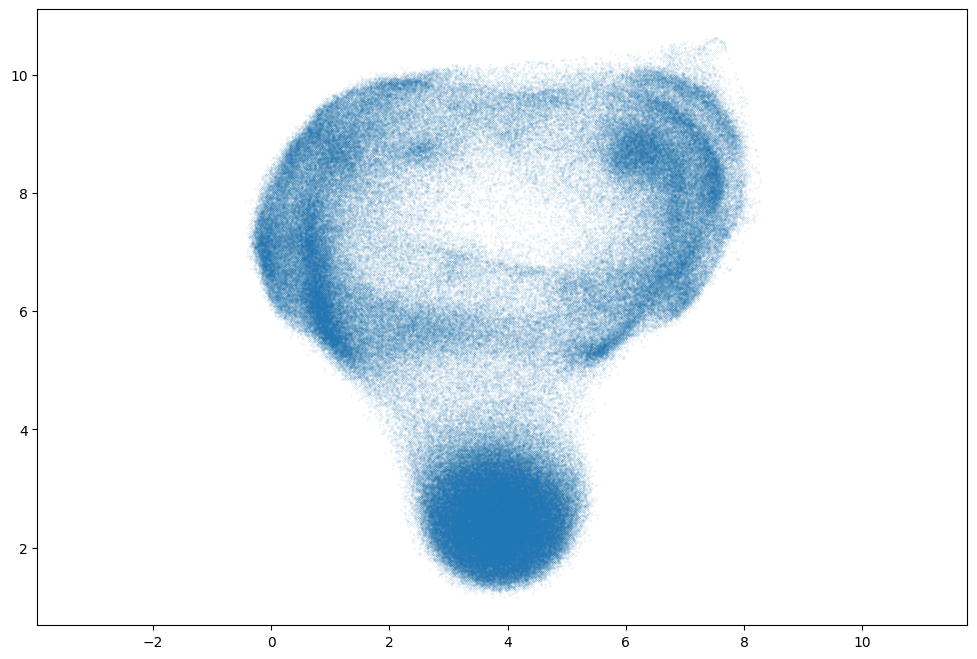

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], alpha=0.4, s=0.02)
plt.gca().set_aspect('equal', 'datalim')
plt.show()

layer3: se le sacaron las funciones de activacion a las layers y la normalización. 